# AC - GAN 


## Libraries

Needed libraries are added at the begining

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import glob
from torchvision.io import read_image
import torch.optim as optim
import torchvision.utils as vutils
from tqdm import tqdm
# for working with google colab use this instead:
# from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

## Default Device

`default_device` is defined to see if the operating system have a `GPU` to use or not

In [2]:
if torch.cuda.is_available(): print(torch.cuda.get_device_name()) 
else: print('cpu')
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce GTX 1660 Ti


## Loading Data

To load our image dataset we need to creat a data loader class. This class gets root location of our dataset folder and needed image transform from torchvision.transforms and read our image dataset and creats a torch.tensor dataset containing images and their class labels

In [586]:
class ImageLoader(Dataset):
    
    '''
        Arguments:
            root: Insert root location for dataset folder like './Dataset/'
            transform: Incert needed transform
    '''
    
    def __init__(self, root, transform):
        self.transform = transform
        self.data = []
        folder_paths = glob.glob(root + '/*')
        self.data_paths = {1:None, 2:None ,3:None ,4:None, 5:None}
        for i in range(1,6):
            self.data_paths[i] = glob.glob(folder_paths[i-1] + '/*.png')
        for data_class in self.data_paths.keys():
            for data_path in self.data_paths[data_class]:
                self.data.append([data_path, data_class])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_dir,label = self.data[index]
        img = read_image(img_dir)
        img = self.transform(img)
        return img[0], label-1

Here we define the needed transform. This transform can change input images to 32x32 size images with datatype torch.float and normalize them between -1 and 1

In [587]:
image_size = 32
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ConvertImageDtype(torch.float),
                                transforms.Normalize((0.5), (0.5))])

Then we use use defined `ImageLoader` class and read ourdata set and creat a dataset with batch size 128 with `DataLoader`

In [588]:
root = './Dataset/'
batch_size = 100
dataset = ImageLoader(root=root, transform=transform)
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True)

Here we show a random selection of our training dataset

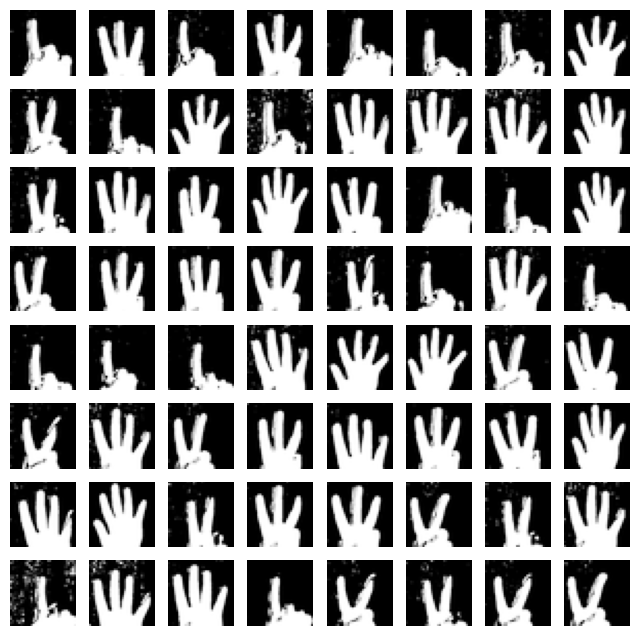

In [589]:
real_batch = next(iter(dataloader))
img = [real_batch[0][i] for i in range(8*8)]
fig , axs = plt.subplots(8 , 8 , figsize=(8 , 8))
cnt = 0
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(img[cnt], cmap=plt.cm.Greys_r)
        axs[i,j].axis('off')
        cnt += 1
plt.show()

## Model

Now we need to define our model. ACGAN contains two parts:<br>
1. Generator 
2. Discriminator

### Generator

Generator job is to creat images from a random noise space with given size. This network contains deconvolution layers and generate a 32x32 images from a latent noise vectoe of lenght 100 in which first 5 elements of this vector shows which class should be generated <br>
The network architecture is as below:

In [590]:
# Size of z latent vector (i.e. size of generator input):
nz = 100
# Size of feature maps in generator:
ngf = 64
# Number of channels in the training images. For grey images this is 1:
nc = 1

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz,
                               out_channels=ngf*8,
                               kernel_size=2,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=ngf*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=ngf*8, 
                               out_channels=ngf*4,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=ngf*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=ngf*4,
                               out_channels=ngf*2,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=ngf*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=ngf*2,
                               out_channels=ngf,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=ngf,
                               out_channels=nc,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.generator(input)


Here is `Generator` and its summary

In [591]:
netg = Generator().to(default_device)
summary(netg, [batch_size,nz,1,1])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [100, 1, 32, 32]          --
├─Sequential: 1-1                        [100, 1, 32, 32]          --
│    └─ConvTranspose2d: 2-1              [100, 512, 2, 2]          204,800
│    └─BatchNorm2d: 2-2                  [100, 512, 2, 2]          1,024
│    └─ReLU: 2-3                         [100, 512, 2, 2]          --
│    └─ConvTranspose2d: 2-4              [100, 256, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-5                  [100, 256, 4, 4]          512
│    └─ReLU: 2-6                         [100, 256, 4, 4]          --
│    └─ConvTranspose2d: 2-7              [100, 128, 8, 8]          524,288
│    └─BatchNorm2d: 2-8                  [100, 128, 8, 8]          256
│    └─ReLU: 2-9                         [100, 128, 8, 8]          --
│    └─ConvTranspose2d: 2-10             [100, 64, 16, 16]         131,072
│    └─BatchNorm2d: 2-11                 [100, 64, 16, 16]

### Discriminator

Discriminator job is to find out that if an input image is a real image or it is generated by the generator and label it as a fake or real image. Also it should be able to classify the output in one-hot form to see which class dose the input image belongs to. By this we can learn our network to create better images <br>
The network architecture is as below:

In [592]:
# Size of feature maps in discriminator:
ndf = 64
# Number of channels in the training images. For grey images this is 1:
nc = 1

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=nc,
                      out_channels=ndf,
                      kernel_size=2,
                      stride=1,
                      padding=2,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            nn.Conv2d(in_channels=ndf,
                      out_channels=ndf*2,
                      kernel_size=2,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=ndf*2),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            nn.Conv2d(in_channels=ndf*2,
                      out_channels=ndf*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=ndf*4),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True),
            nn.Conv2d(in_channels=ndf*4,
                      out_channels=ndf*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(num_features=ndf*8),
            nn.LeakyReLU(negative_slope=0.2,
                         inplace=True)
        )
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=ndf*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=ndf*8,
                      out_channels=5,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.feature_extractor(input)
        d = self.discriminator(x)
        c = self.classifier(x)
        return d, c

Here is `Discriminator` and its summary

In [593]:
netd = Discriminator().to(default_device)
summary(netd, [batch_size,1,32,32])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [100, 1]                  --
├─Sequential: 1-1                        [100, 512, 4, 4]          --
│    └─Conv2d: 2-1                       [100, 64, 35, 35]         256
│    └─LeakyReLU: 2-2                    [100, 64, 35, 35]         --
│    └─Conv2d: 2-3                       [100, 128, 18, 18]        32,768
│    └─BatchNorm2d: 2-4                  [100, 128, 18, 18]        256
│    └─LeakyReLU: 2-5                    [100, 128, 18, 18]        --
│    └─Conv2d: 2-6                       [100, 256, 9, 9]          524,288
│    └─BatchNorm2d: 2-7                  [100, 256, 9, 9]          512
│    └─LeakyReLU: 2-8                    [100, 256, 9, 9]          --
│    └─Conv2d: 2-9                       [100, 512, 4, 4]          2,097,152
│    └─BatchNorm2d: 2-10                 [100, 512, 4, 4]          1,024
│    └─LeakyReLU: 2-11                   [100, 512, 4, 4]      

## Training

Now that we defined our ACGAN network, we need to train both `Generator` and `Discrininator` simultaneously <br>
To do so we define learing parameters as bellow:

In [594]:
def noise_gen(b_size=batch_size , device=default_device):
    noise = torch.randn(b_size, 95, 1, 1, device=device)
    z = torch.zeros(b_size)
    tmp = int(b_size/5)
    for i in range(5):
        z[i*tmp:(i+1)*tmp] = i
    lbl = z.to(device).to(int)
    z = nn.functional.one_hot(z.to(int)).reshape(b_size , 5 , 1 , 1)
    return torch.concat([noise , z.to(device)] , dim=1) , lbl

In [595]:
# Initialize BCELoss function
criterion_rf = nn.BCELoss()
criterion_cl = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
fixed_noise = noise_gen()[0].to(default_device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netd.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netg.parameters(), lr=0.0002, betas=(0.5, 0.999))

Here is our training loop. we train our network for 200 epochs and save loss and accuracy scores calculated in each epoch

In [596]:
# Training Loop

epochs = 200

# Lists to keep track of progress
G_losses = []
D_losses = []
G_acc = []
D_acc = []
D_xs = []
D_G_zs = []
img_list = []
iters = 0

loss_D = 0.0
Loss_G = 0.0
D_x = 0.0
D_G_z1 = 0.0
D_G_z2 = 0.0

# For each epoch
for epoch in range(epochs):
    # For each batch
    desc= f'epoch {epoch+1:3} / {epochs}'
    postfix = f'Loss_D: {loss_D:7.4f}, Loss_G: {Loss_G:7.4f}, D(x): z {D_x:7.4f} , D(G(z)): {D_G_z1:7.4f} | {D_G_z2:7.4f}'
    for i, (img , lbl) in tqdm(enumerate(dataloader), desc=desc, postfix=postfix):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

        ## Train with all-real batch
        netd.zero_grad()
        # Ready Data
        b_size = img.shape[0]
        real_img = torch.reshape((img),(b_size,1,32,32)).to(default_device)
        real_lbl = lbl.to(default_device)
        label = torch.full((b_size,), real_label, device=default_device)
        # Forward pass real batch through D
        output , classes = netd(real_img)
        # Calculate loss on all-real batch
        errD_real_rf = criterion_rf(output.view(-1), label)
        errD_real_cl = criterion_cl(classes, real_lbl)
        # Calculate gradients for D in backward pass
        errD_real = errD_real_rf + errD_real_cl
        errD_real.backward()
        D_x = output.mean().item()
        Acc_D = accuracy_score(real_lbl.cpu() ,classes.argmax(1).cpu())

        ## Train with all-fake batch
        noise , fake_lbl = noise_gen(b_size , device=default_device)
        # Generate fake image batch with G
        fake = netg(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output , classes = netd(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake_rf = criterion_rf(output.view(-1), label)
        errD_fake_cl = criterion_cl(classes, fake_lbl)
        errD_fake = errD_fake_rf + errD_fake_cl

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        Acc_D_G_z1 = accuracy_score(fake_lbl.cpu() ,classes.argmax(1).cpu())
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netg.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output , classes = netd(fake)
        # Calculate G's loss based on this output
        errG_rf = criterion_rf(output.view(-1), label)
        errG_cl = criterion_cl(classes, fake_lbl)
        errG = errG_rf + errG_cl
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        Acc_D_G_z2 = accuracy_score(fake_lbl.cpu() ,classes.argmax(1).cpu())
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_acc.append((Acc_D + Acc_D_G_z1)/2)
        G_acc.append(Acc_D_G_z2)

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 4 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netg(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # Save D_x & D_G_z
        D_xs.append(D_x)
        D_G_zs.append((D_G_z1+D_G_z2)/2)

        iters += 1
        loss_G = errG.item()
        loss_D = errD.item()


G_losses_epoch = np.array(G_losses).reshape(epochs , -1).mean(1)
D_losses_epoch = np.array(D_losses).reshape(epochs , -1).mean(1)
G_accuracy = np.array(D_G_zs).reshape(epochs , -1).mean(1)
D_accuracy = np.array(D_xs).reshape(epochs , -1).mean(1)
D_acc_ = np.array(D_acc).reshape(epochs , -1).mean(1)
G_acc_ = np.array(G_acc).reshape(epochs , -1).mean(1)

epoch   1 / 200: 11it [00:02,  5.44it/s, Loss_D:  0.0000, Loss_G:  0.0000, D(x): z  0.0000 , D(G(z)):  0.0000 |  0.0000]
epoch   2 / 200: 11it [00:01,  5.99it/s, Loss_D:  2.7301, Loss_G:  0.0000, D(x): z  0.9703 , D(G(z)):  0.0522 |  0.0014]
epoch   3 / 200: 11it [00:01,  5.99it/s, Loss_D:  2.6279, Loss_G:  0.0000, D(x): z  0.9949 , D(G(z)):  0.0104 |  0.0018]
epoch   4 / 200: 11it [00:01,  5.85it/s, Loss_D:  2.5380, Loss_G:  0.0000, D(x): z  0.9975 , D(G(z)):  0.0050 |  0.0014]
epoch   5 / 200: 11it [00:02,  5.31it/s, Loss_D:  2.5327, Loss_G:  0.0000, D(x): z  0.9976 , D(G(z)):  0.0034 |  0.0016]
epoch   6 / 200: 11it [00:01,  6.15it/s, Loss_D:  2.4551, Loss_G:  0.0000, D(x): z  0.9974 , D(G(z)):  0.0044 |  0.0015]
epoch   7 / 200: 11it [00:01,  5.78it/s, Loss_D:  2.5378, Loss_G:  0.0000, D(x): z  0.9984 , D(G(z)):  0.0031 |  0.0010]
epoch   8 / 200: 11it [00:01,  5.53it/s, Loss_D:  2.5708, Loss_G:  0.0000, D(x): z  0.9992 , D(G(z)):  0.0484 |  0.0000]
epoch   9 / 200: 11it [00:01,  5

[]

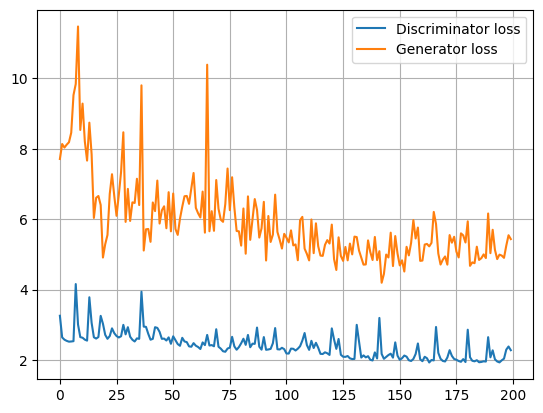

In [597]:
plt.plot(D_losses_epoch, label = 'Discriminator loss')
plt.plot(G_losses_epoch, label = 'Generator loss')
plt.legend()
plt.grid()
plt.plot()

[]

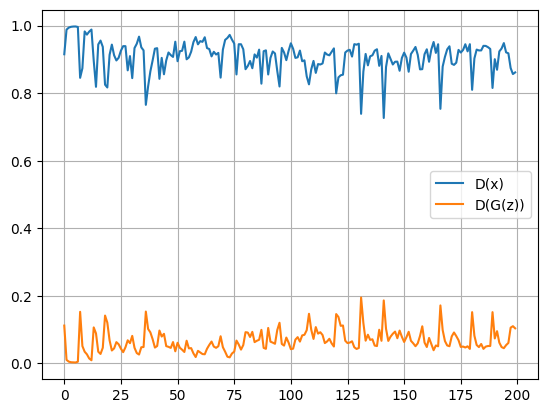

In [598]:
plt.plot(D_accuracy, label = 'D(x)')
plt.plot(G_accuracy, label = 'D(G(z))')
plt.legend()
plt.grid()
plt.plot()

[]

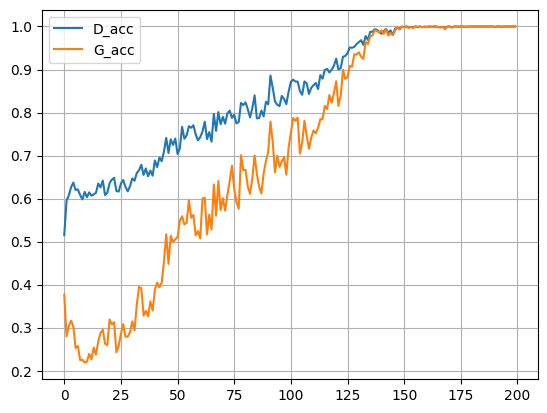

In [599]:
plt.plot(D_acc_, label = 'D_acc')
plt.plot(G_acc_, label = 'G_acc')
plt.legend()
plt.grid()
plt.plot()

Now the training cycle is complete

## Evaluation

Now that our model is trained, we need to evaluate the model and see the results of generator and judge the outputs and see if the results are acceptable<br>
To do so we creat a random vector with batch_size and the size of z latent vector to feed to the generator

In [601]:
b_size_t = 8*5
test_batch = noise_gen(b_size_t,default_device)[0]

Here we feed the latent vector to our generator and get the outputs

In [602]:
test_output = netg(test_batch.to(default_device))
test_output = torch.reshape(test_output,(b_size_t,image_size,image_size))
test_output = test_output.cpu().detach().numpy()
test_output.shape

(40, 32, 32)

To evaluate our results we can see the outputs as bellow:

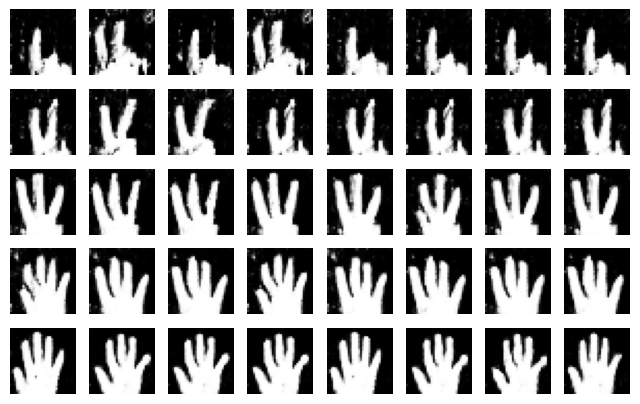

In [603]:
img = [test_output[i] for i in range(8*5)]
fig , axs = plt.subplots(5 , 8 , figsize=(8 , 5))
cnt = 0
for i in range(5):
    for j in range(8):
        axs[i,j].imshow(img[cnt], cmap=plt.cm.Greys_r)
        axs[i,j].axis('off')
        cnt += 1
plt.show()